In [1]:
from functools import reduce
from operator import or_, add
from random import randint
from itertools import product
from collections import deque

import cv2
from matplotlib.pyplot import imshow, figure
import numpy as np
from numpy import array, flip

# pylint: disable=undefined-variable
%matplotlib inline

## Morphing

In [2]:
def cross(shape):
    return cv2.getStructuringElement(cv2.MORPH_CROSS, shape)

def circle(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

def cvclose(image, kernel):
    return cv2.erode(cv2.dilate(image, kernel), kernel)

# m-adjacent neighbors

 For a given image $I$ and a mask $M$, pixel $p, q$ are
 considered m-adjacent if one of the following is true
 
  1. $q$ is a 4-adjcent of $p$ where $p,q\in M$
  2. $q$ is diagonal of $q$ where $p, q\in M$ *and*
     there is no $\omega\in M$ where $\omega$ 
     is both 4-adjecent of $p$ and 4-adjecent of $q$


In [3]:
def is_in_image(pixel, shape):
    r, c = pixel
    rows, cols = shape
    return ((0 <= r < rows) and
            (0 <= c < cols))

def adjesent_m(pixel, mask):
    def is_in(pixel):
        r, c = pixel
        return is_in_image((r, c), mask.shape) and mask[r, c]
    
    def add_offset(offset):
        return tuple(map(add, pixel, offset))
    
    neighbors_4 = [offset
                   for offset in [(1, 0), (0, 1), (-1, 0), (0, -1)]
                   if is_in(add_offset(offset))]
    
    neighbors_diag = [(o_r, o_c)
                      for o_r, o_c in [(1, 1), (-1, 1), (-1, -1), (1, -1)]
                      if set([(0, o_r), (o_c, 0)]).isdisjoint(neighbors_4) and is_in(add_offset((o_r, o_c)))]
    
    return [add_offset(offset) for offset in neighbors_4 + neighbors_diag]

## Convertions

In [4]:
def uint8(image):
    return image.astype(np.uint8)

def arrayuint8(rows):
    return uint8(array(rows))

## Display

In [5]:
def imshow_gray(image, figsize=(50, 50)):
    figure(figsize=figsize)
    imshow(image, cmap='gray')
    
def as_display(image):
    return cv2.cvtColor(cv2.normalize(image.astype(np.float),
                                      None,
                                      0,
                                      255,
                                      cv2.NORM_MINMAX).astype(np.uint8),
                        cv2.COLOR_GRAY2RGB)

def rand_color():
    return (randint(150, 200), randint(150, 200), randint(0, 255))

def show_lines(image, lines):
    image_with_lines = as_display(image)
    for point1, point2 in lines:
        cv2.line(image_with_lines, point1, point2, rand_color(), 1)
        
    return image_with_lines

def show_points(image, points, radius=2):
    image_with_circles = as_display(image)
    randcolor = (100, randint(150, 200), randint(0, 255))
    for point in points:
        cv2.circle(image_with_circles, point, radius, randcolor, thickness=-1)
    return image_with_circles

# Input

We get a text document as input

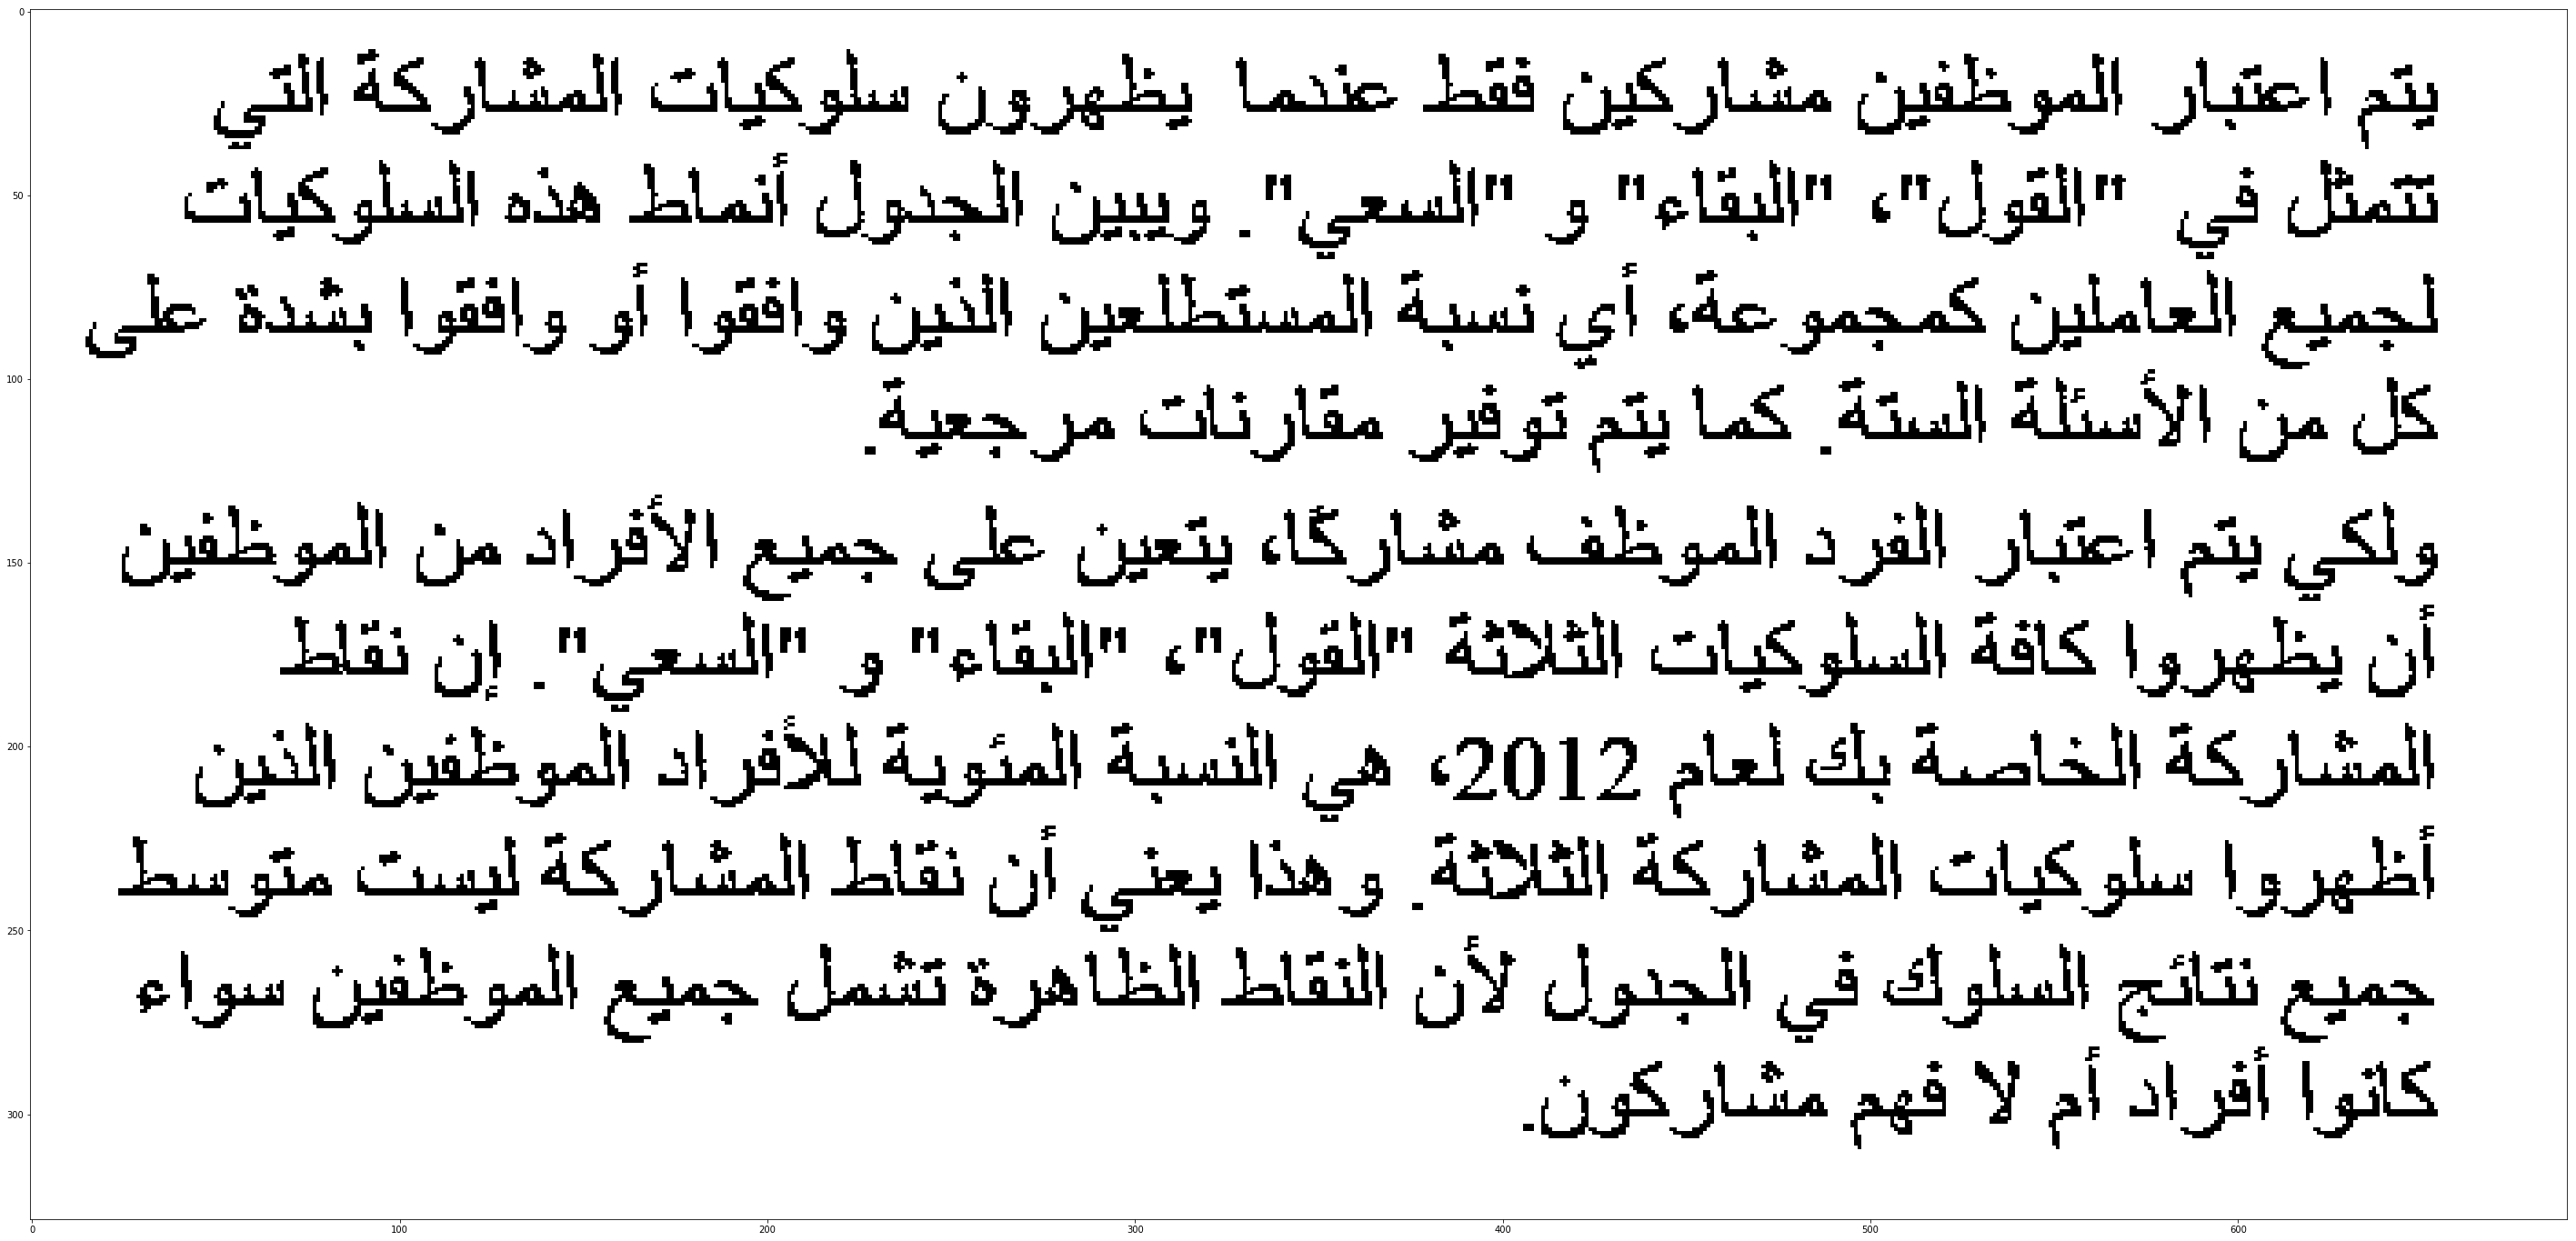

In [6]:
TEXT = cv2.threshold(src=cv2.imread("arabic.jpg", cv2.IMREAD_GRAYSCALE),
                     thresh=200,
                     maxval=1,
                     type=cv2.THRESH_BINARY)[1]

imshow_gray(TEXT)

# Erode
We erode input to emphasize words

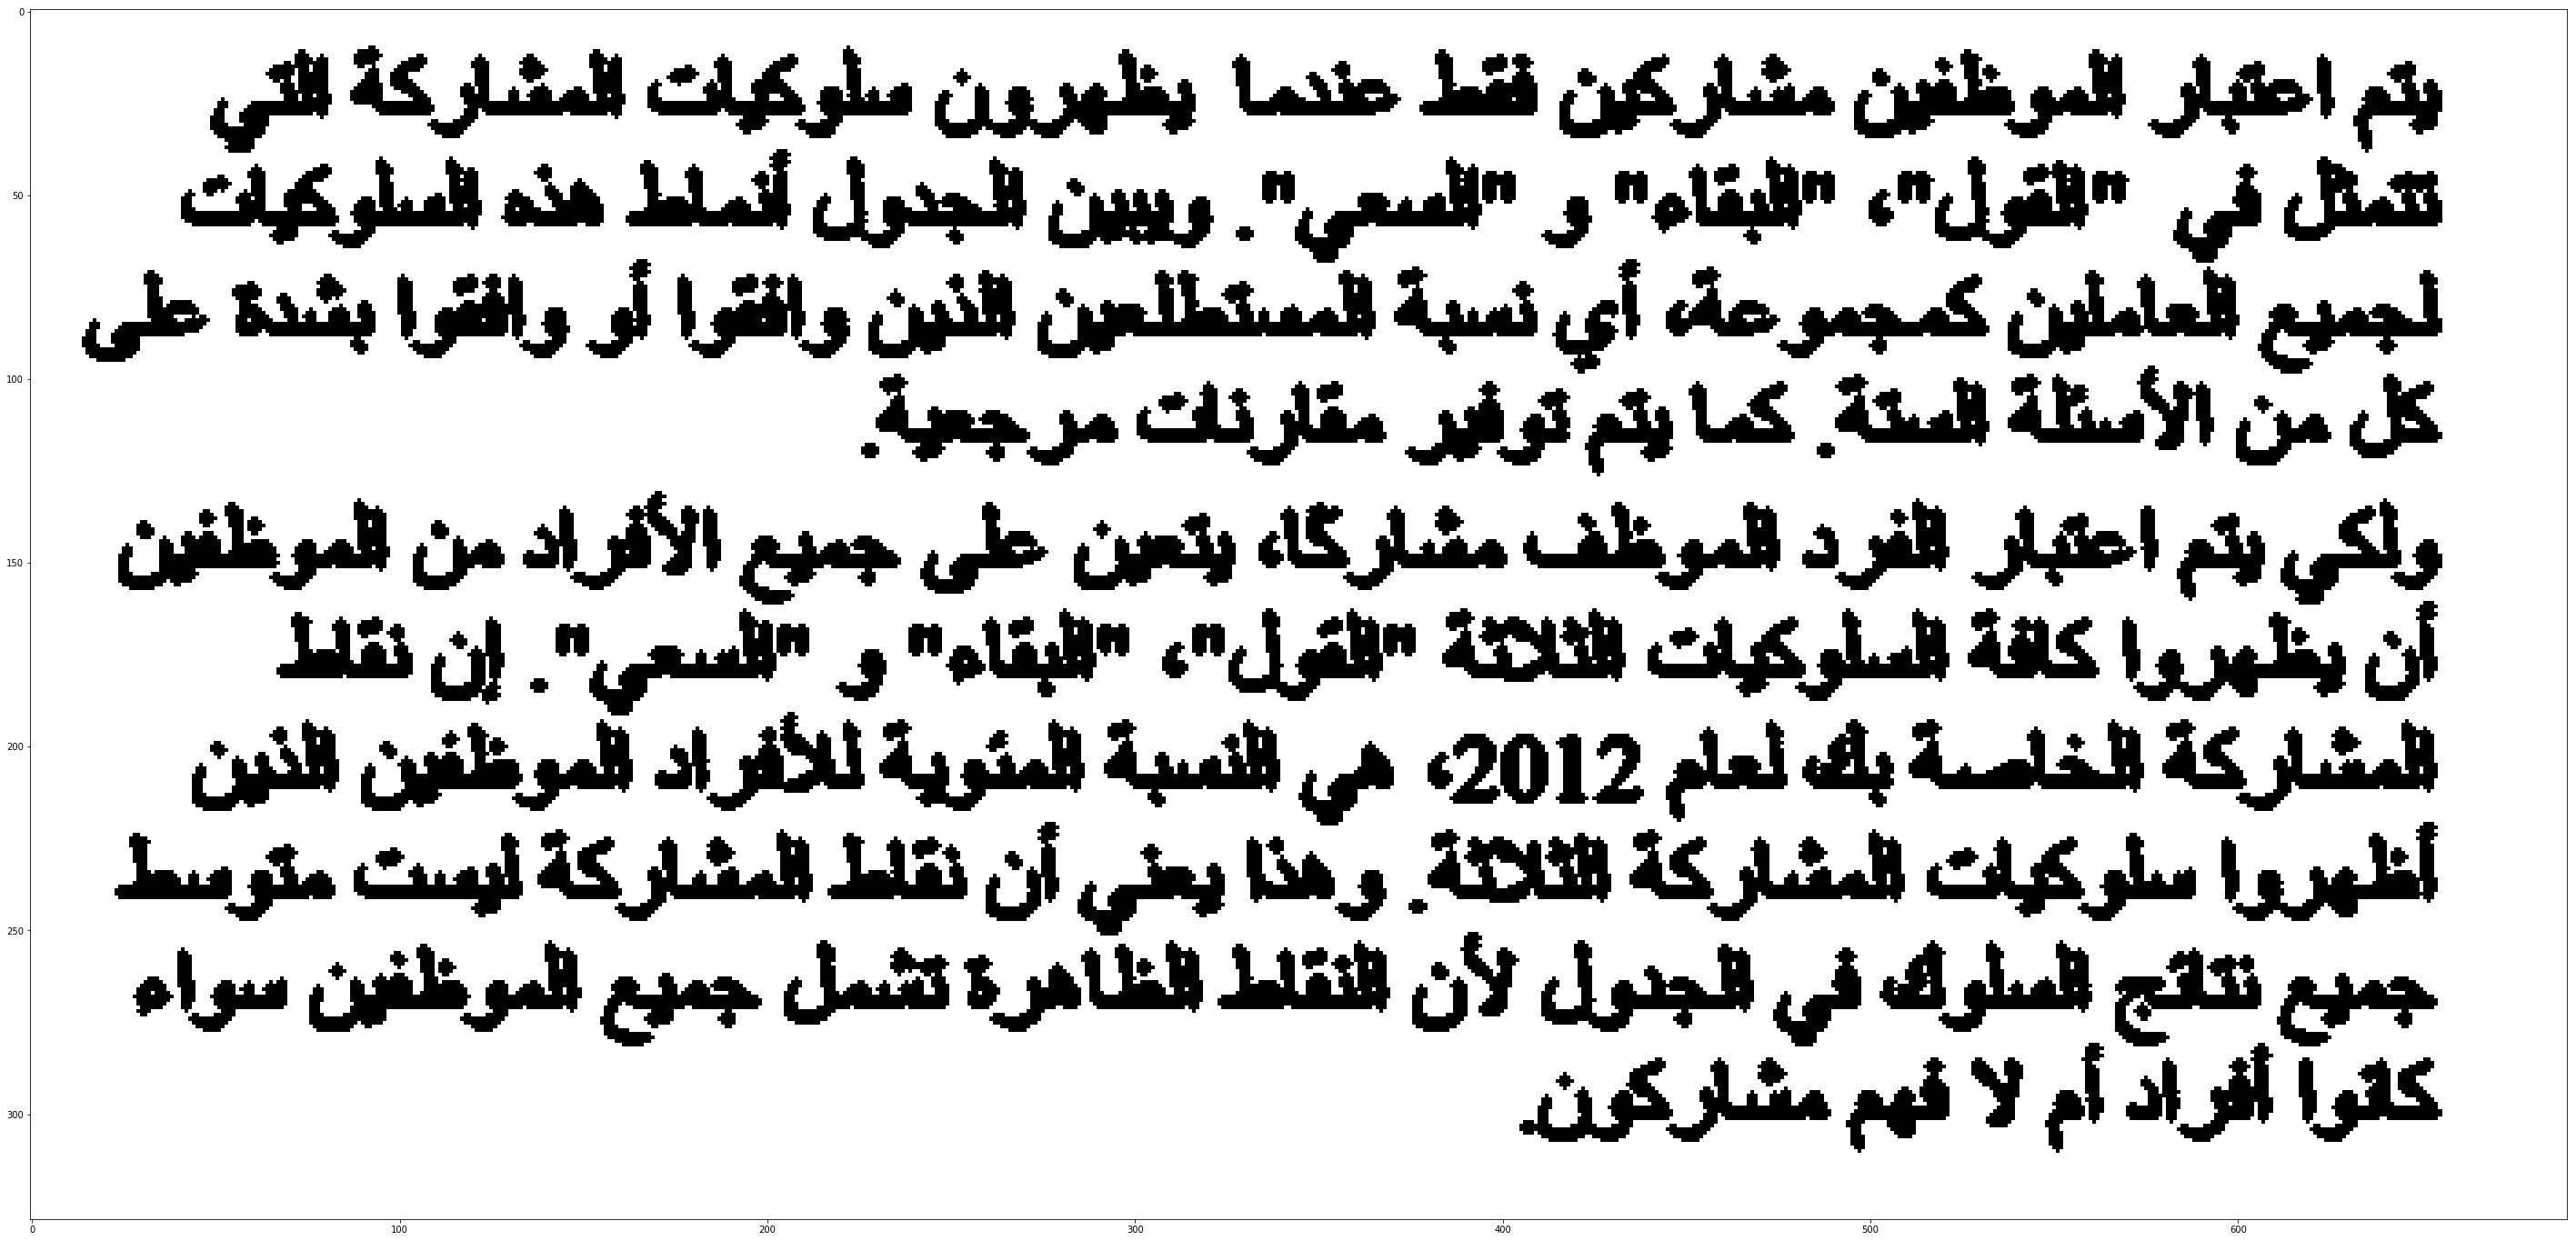

In [19]:
TEXT_ERODE=cv2.erode(TEXT, circle(3))
imshow_gray(TEXT_ERODE)

# Distance transform

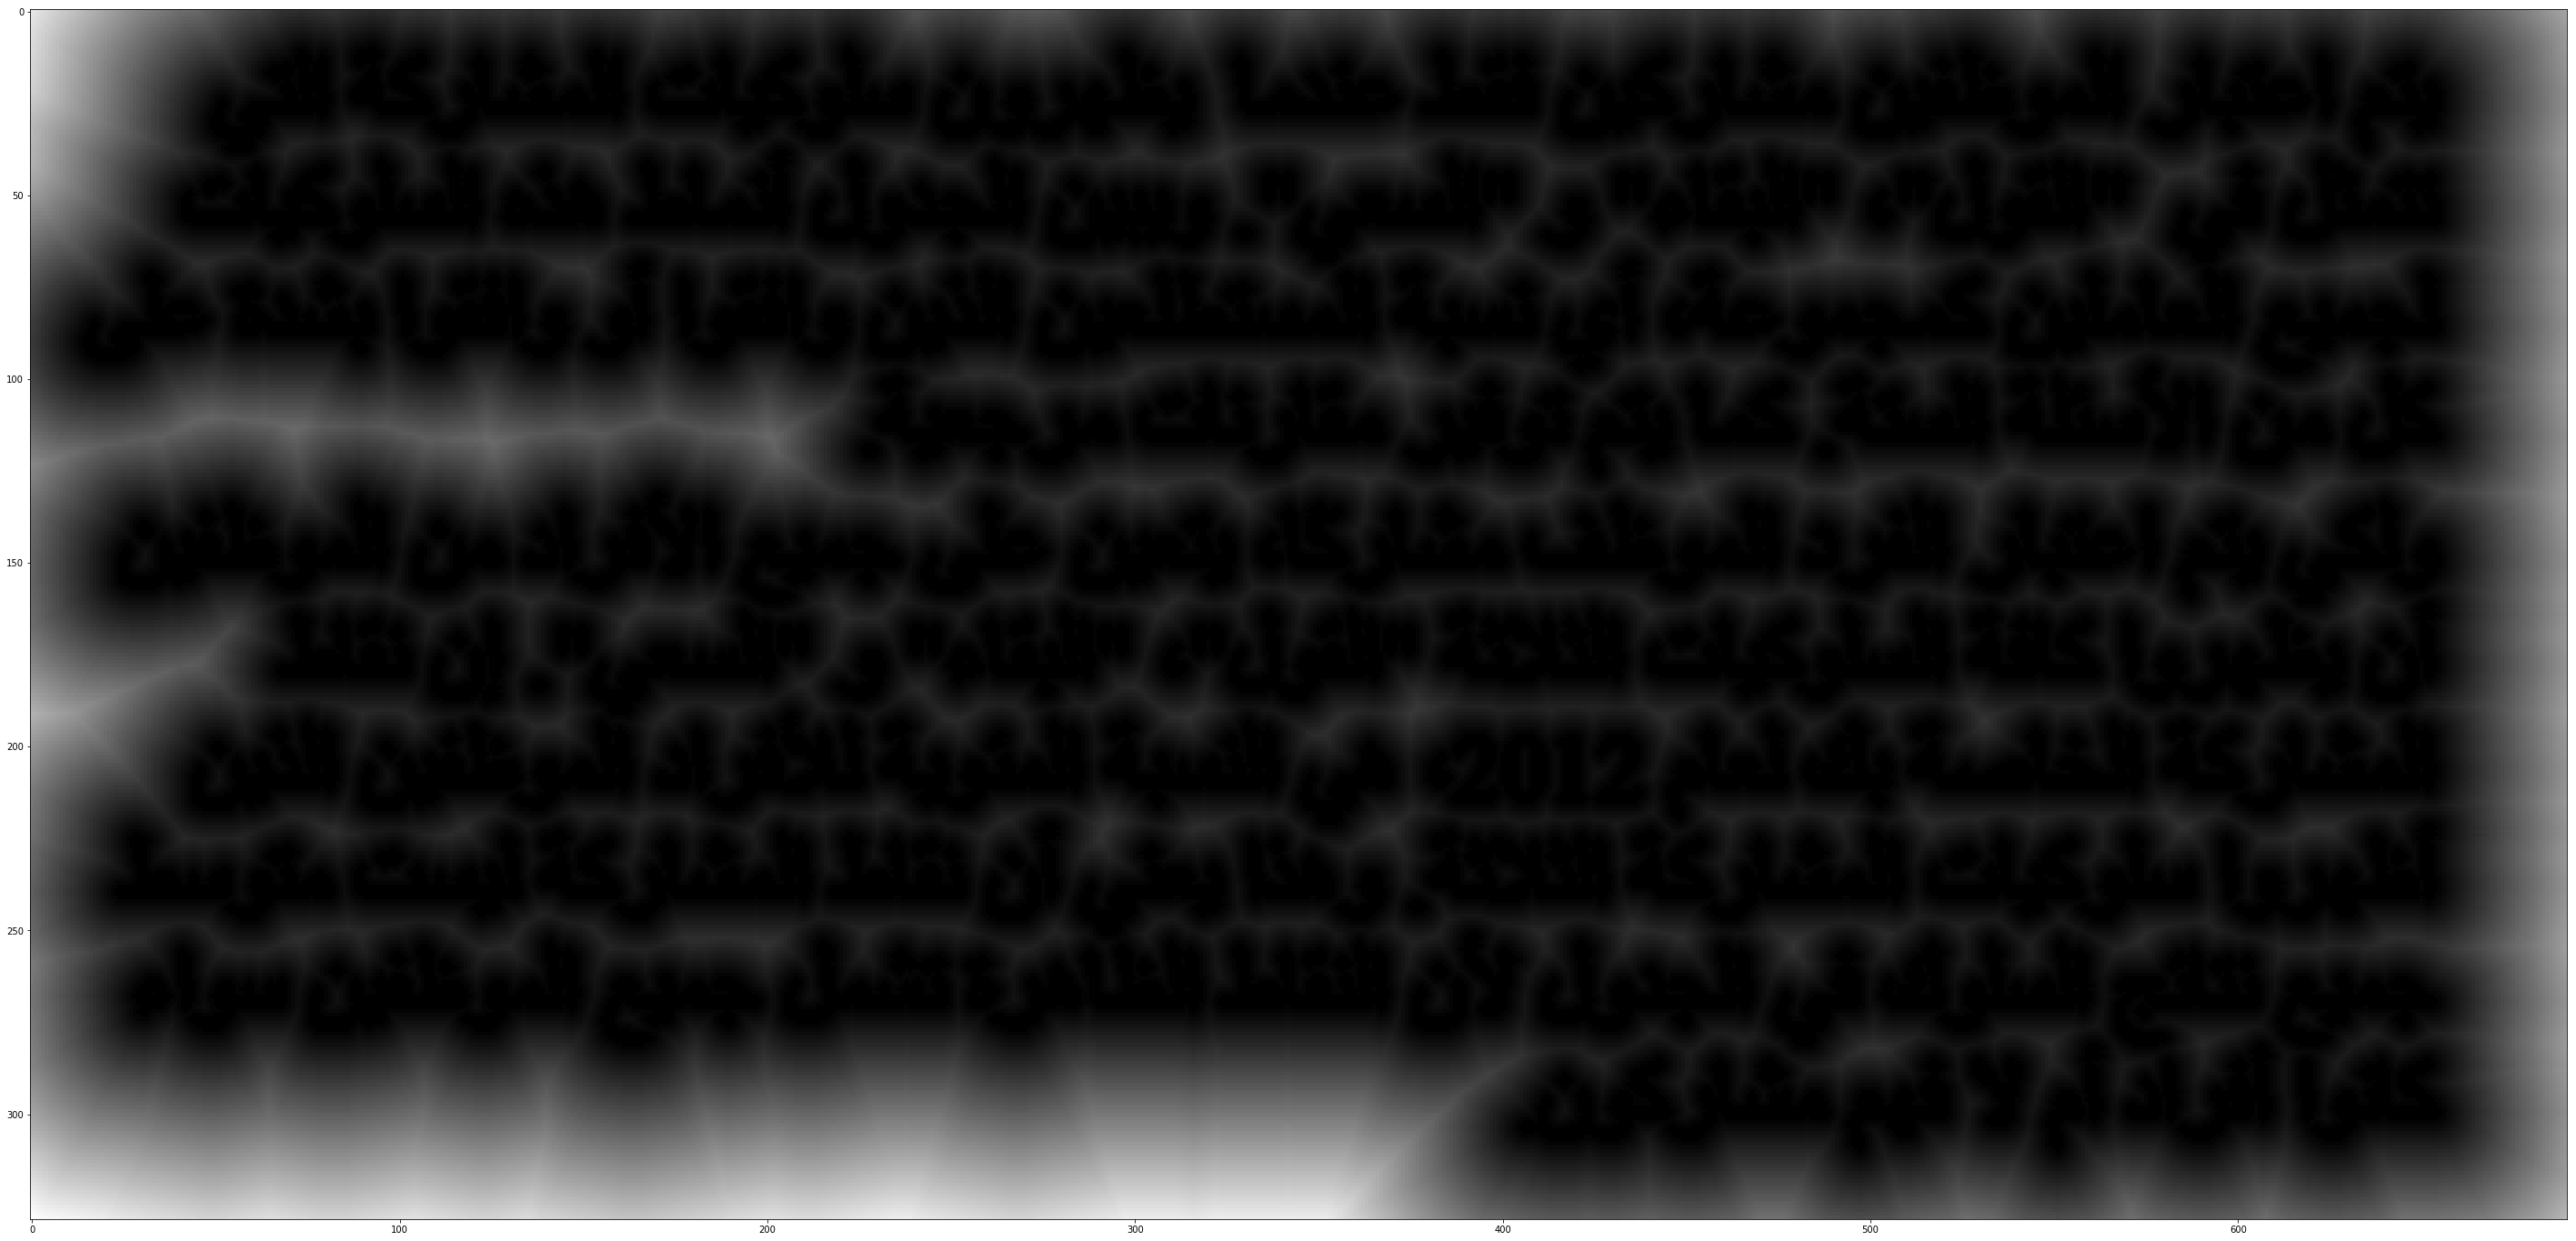

In [8]:
DIST = cv2.distanceTransform(TEXT_ERODE, cv2.DIST_L2, cv2.DIST_MASK_5)
imshow_gray(DIST)

# Local maxima

Each pixel $p$ is consider local maximum if $p > q_1 \wedge p> q_2$

for some $q_1, q_1$ where $q_1, q_2$ are opposite pixels in the 8-member inviroment of $p$

In [9]:
def local_maxima(image):
    horizontal = arrayuint8(
        [[0, 0, 0],
         [1, 0, 1],
         [0, 0, 0]])

    diagonal = arrayuint8(
        [[1, 0, 0],
         [0, 0, 0],
         [0, 0, 1]])

    kernels = [horizontal, horizontal.T, diagonal, flip(diagonal, 1)]

    local_maximas = (image > cv2.dilate(image, kernel)
                     for kernel in kernels)

    return uint8(reduce(or_, local_maximas))

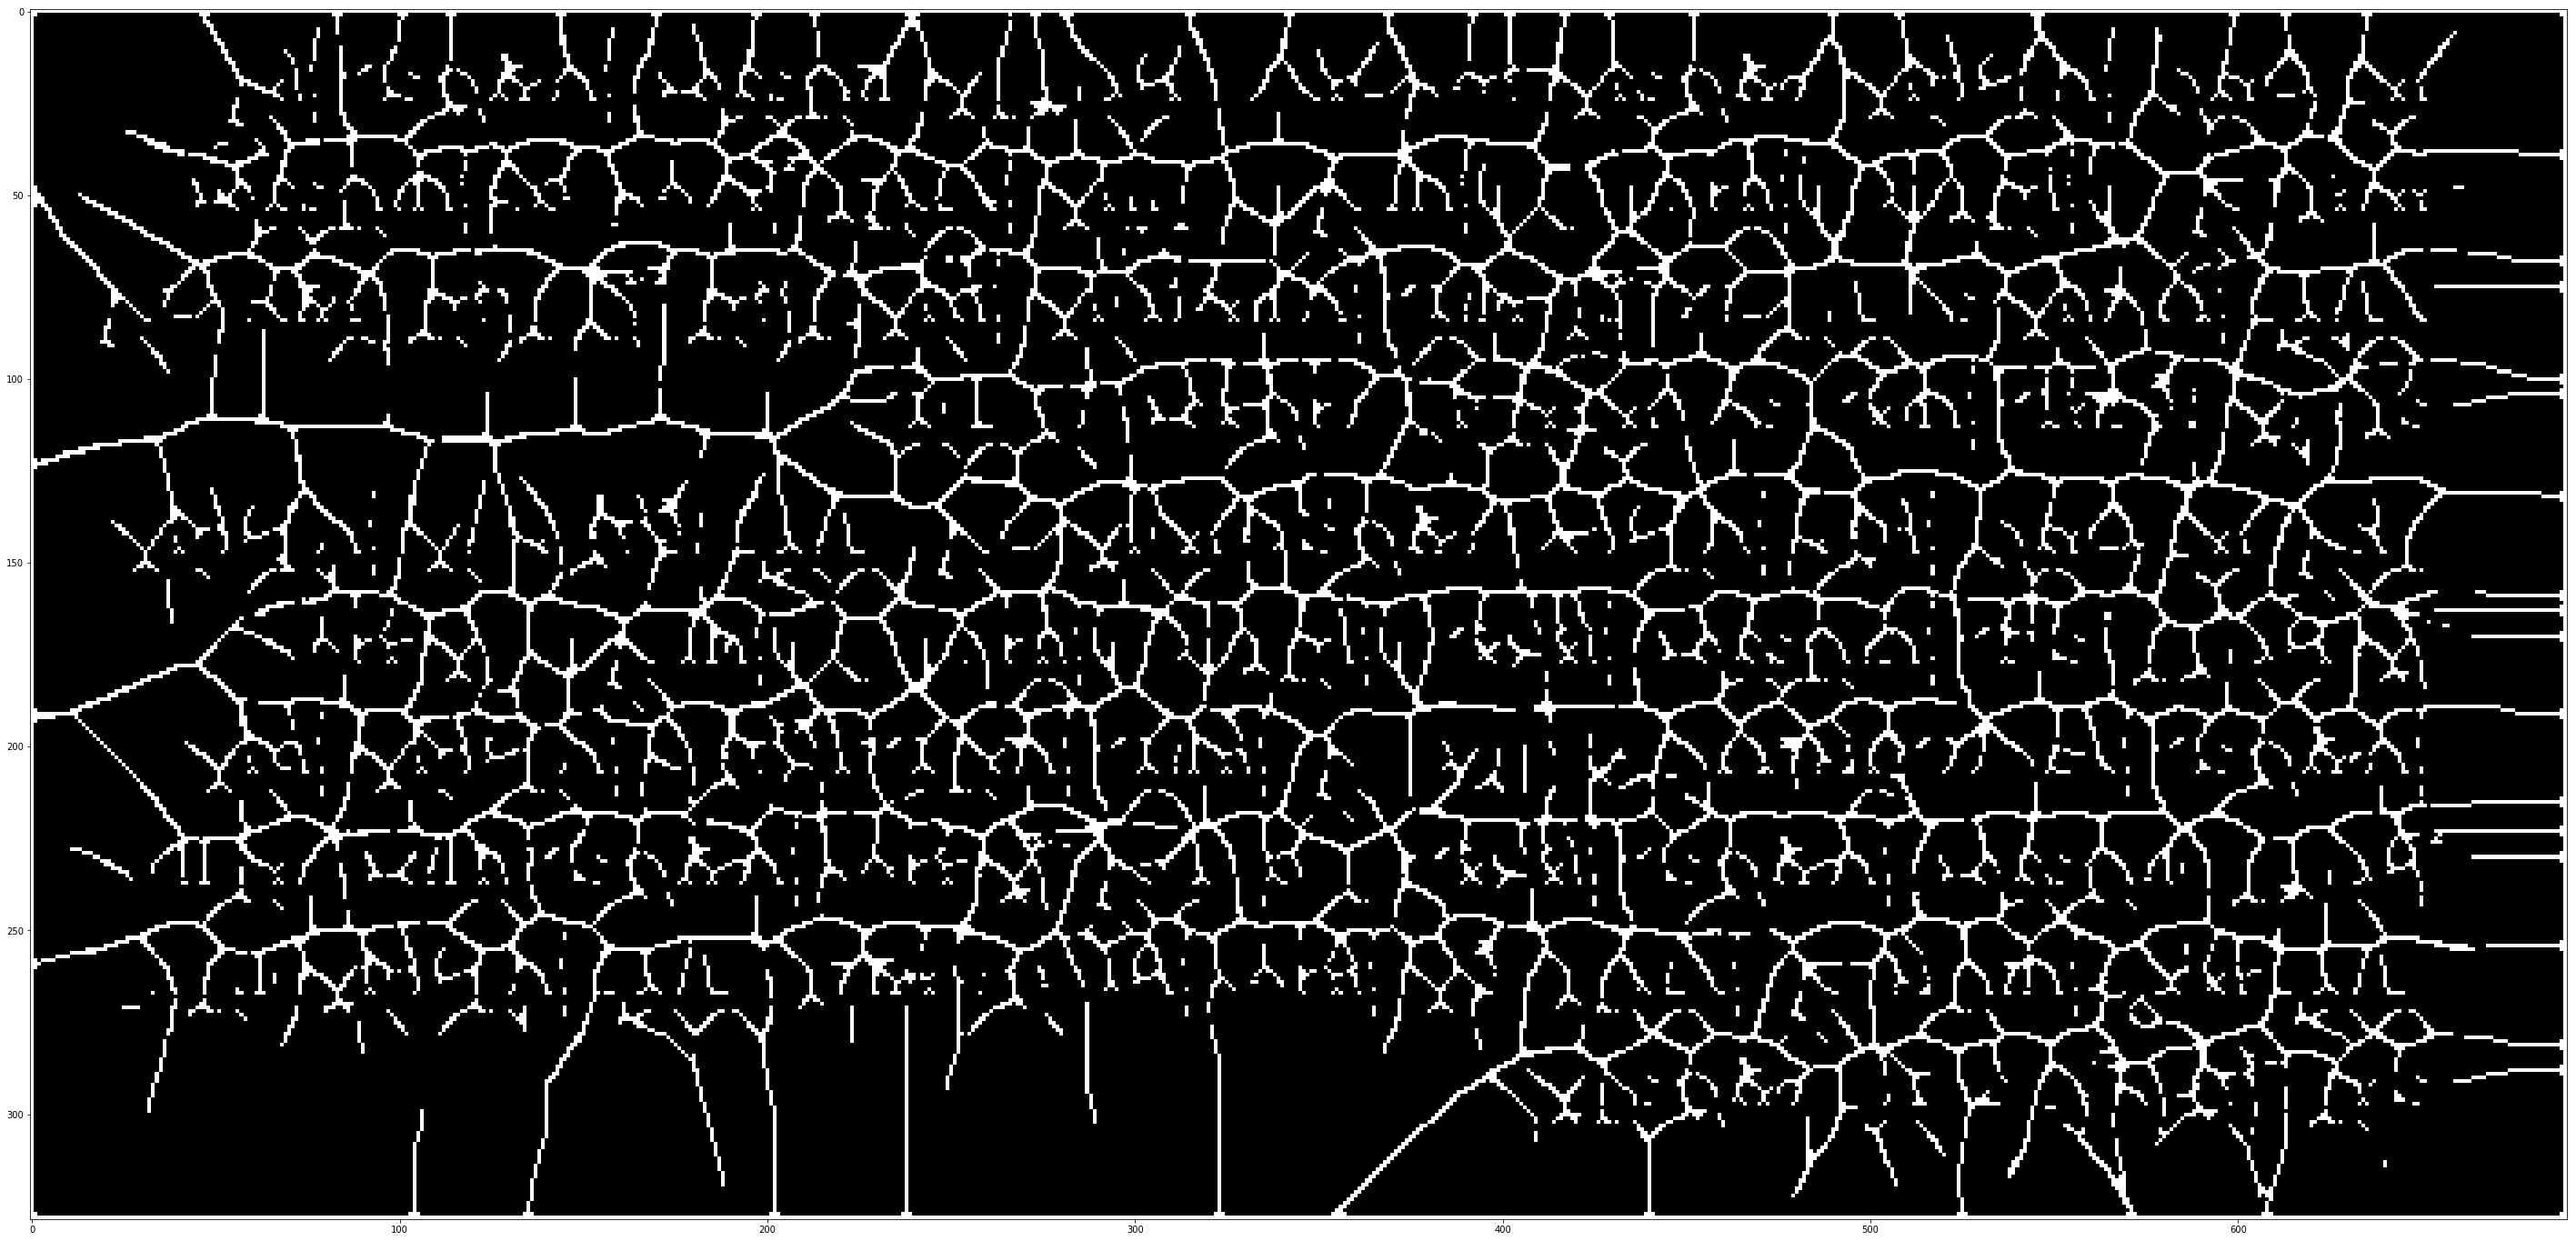

In [10]:
LOCAL_DIST_MAXIMA = cvclose(local_maxima(DIST), cross((3, 3)))

imshow_gray(LOCAL_DIST_MAXIMA, figsize=(50, 50))

# Graph

We extract the vertices and the edges from the local maxima matrix

## Neighbor counting
1. For a pixel $p$ it is defined it has a neighbors in a direction $d$ , if it has non-zero pixels in that direction.
2. We count of number of directions a pixel has neighbors on. we get a number in $0\dots4$.
   
   e.g, a pixel with one neighbor (left) and a pixel with two neighbors(right):
   
   $\begin{pmatrix}0&0&0&0&0\\0&0&0&0&0\\0&0&\textbf{p}&0&0\\0&0&1&0&0\\0&0&1&0&0 \end{pmatrix} \qquad\begin{pmatrix}0&0&0&0&0\\0&0&0&0&0\\0&0&\textbf{p}&1&1\\0&0&1&0&0\\0&0&1&0&0 \end{pmatrix}$

In [11]:
def rotations(matrix):
    return [matrix, matrix.T, flip(matrix, 0), flip(matrix.T, 1)]

def neighbor_count(binary_matrix):
    down = arrayuint8(
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0]])

    down_right = arrayuint8(
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0]])

    down_up_right = arrayuint8(
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0]])


    sides = zip(*map(rotations, (down,
                                 down_right,
                                 flip(down_right, 1),
                                 down_up_right,
                                 flip(down_up_right, 1)
                                )))

    neighbors = [uint8(reduce(or_, (cv2.erode(binary_matrix, kernel)
                                    for kernel in kernels)))
                 for kernels in sides]

    res = reduce(add, neighbors)

    res[0, :] = 0
    res[:, 0] = 0
    res[-1, :] = 0
    res[:, -1] = 0
    return res

## Centeroids
1. Let $FM$ be pixels $p$ with [neighbor count](#Neighbor-counting) $n(p) > 2$ 
2. Graph vertices are defined as the centeroids of connected components of $FM$ 

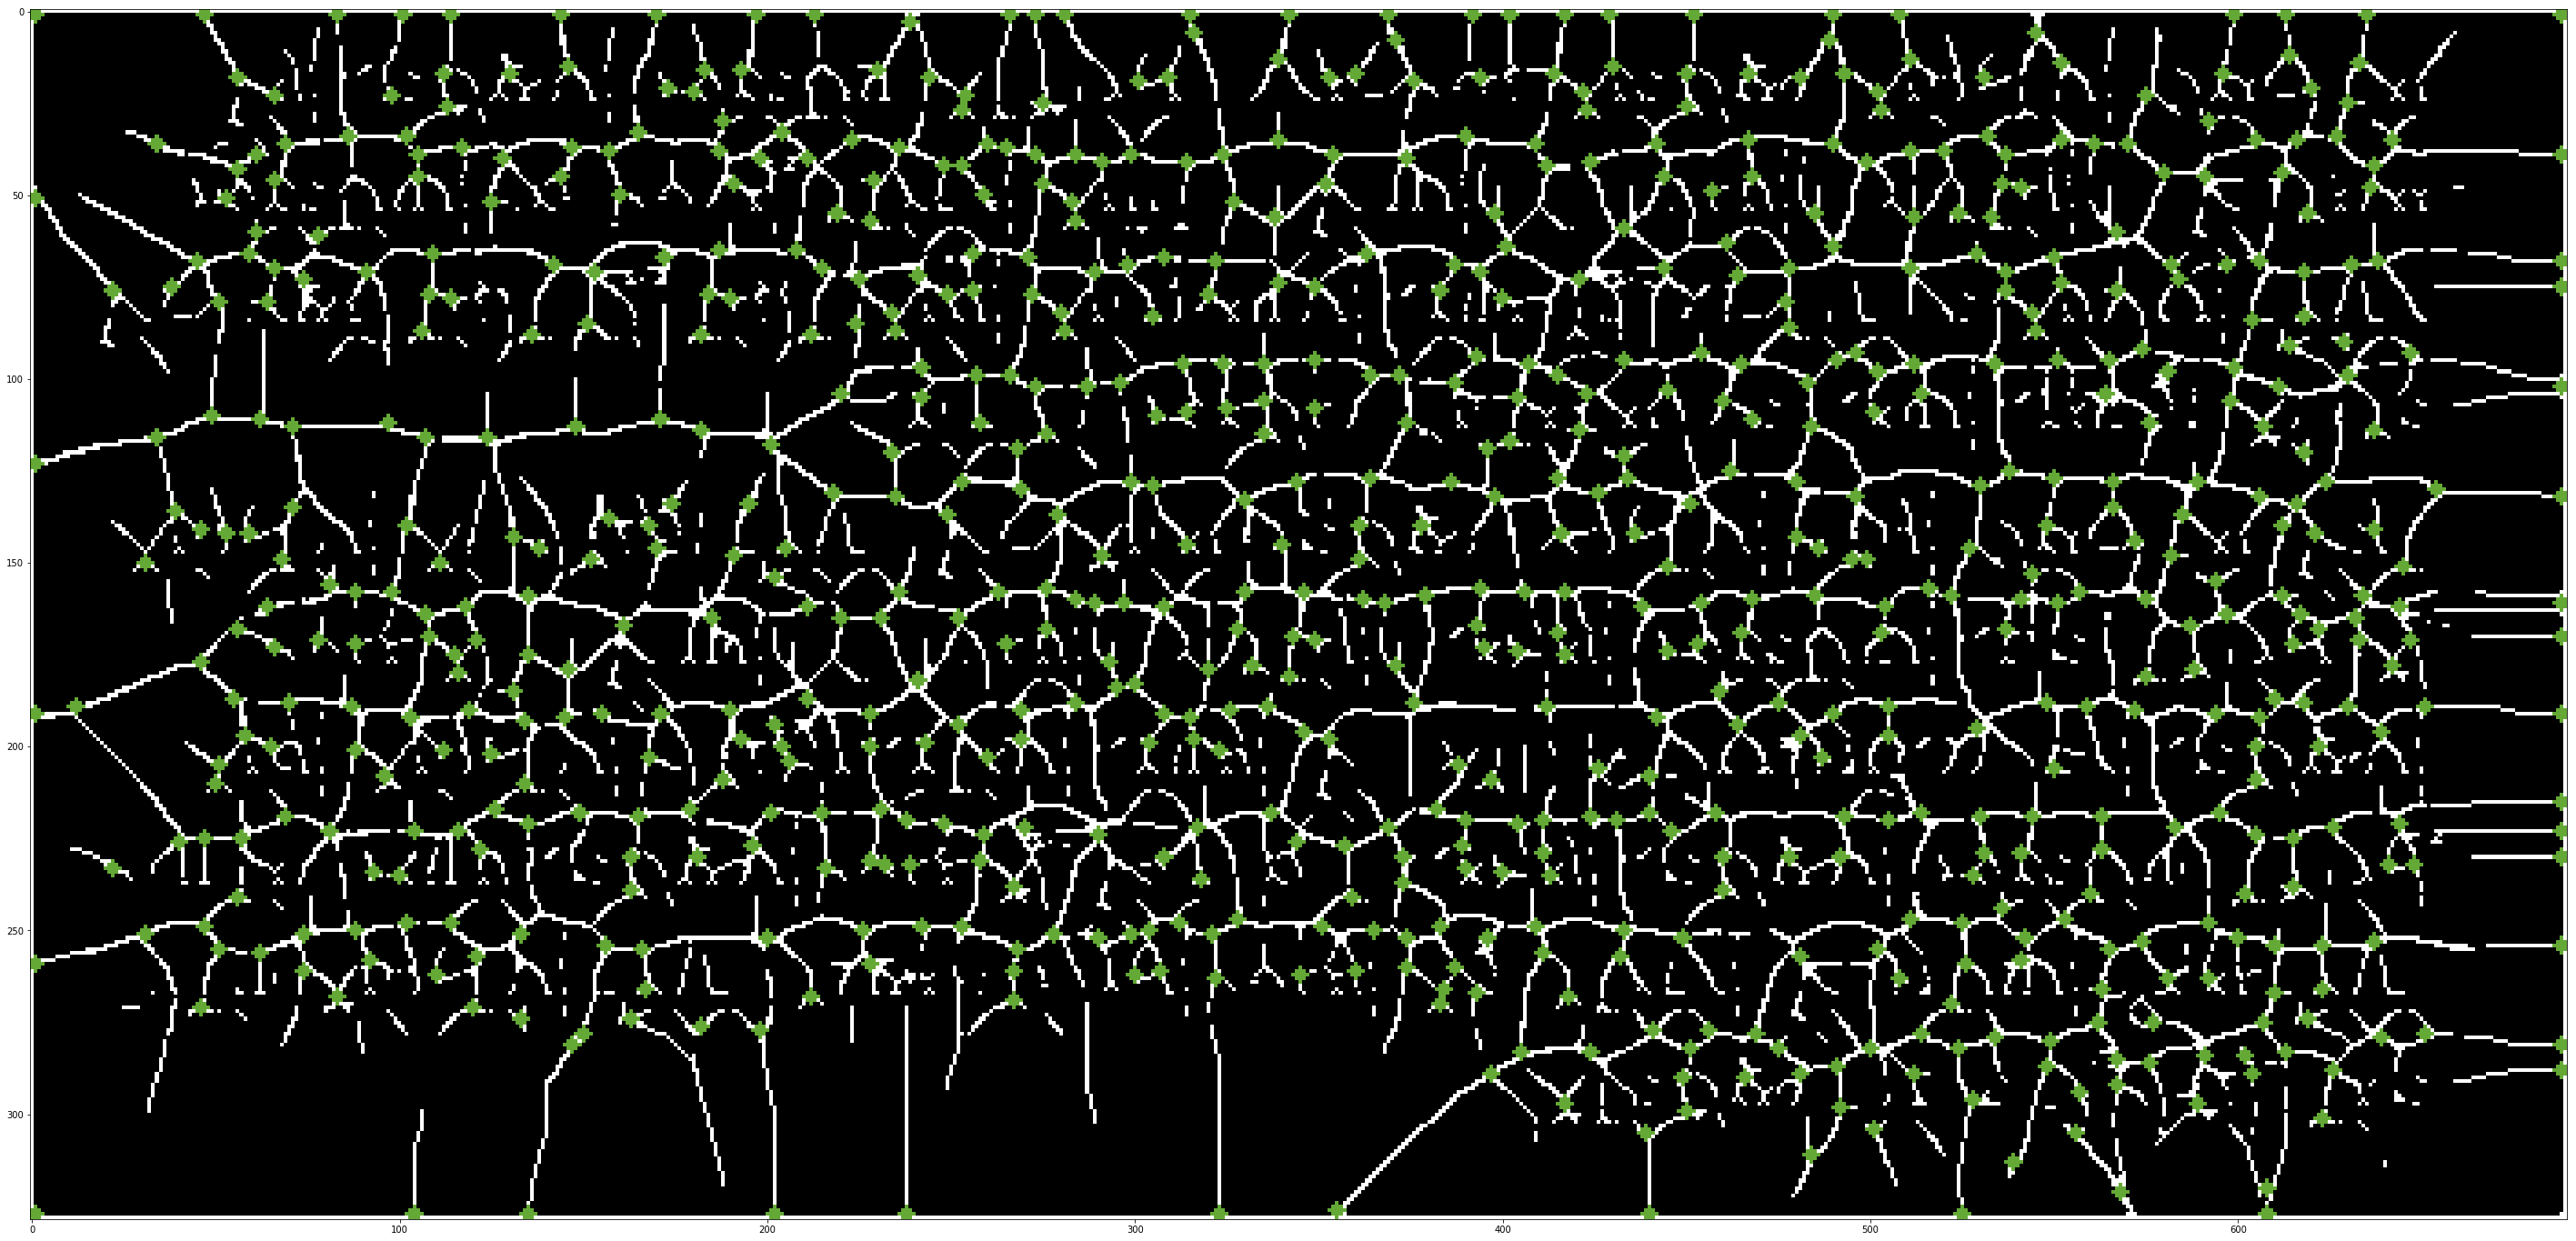

In [12]:
def vertices(skeleton):
    vertex_pixels = uint8((neighbor_count(skeleton) > 2))
    centeroids = cv2.connectedComponentsWithStats(cv2.dilate(vertex_pixels, cross((3, 3))))[-1]
    return [tuple(map(int, point)) for point in centeroids[1:-1]]


LOCAL_MAX_VERTS = vertices(LOCAL_DIST_MAXIMA)
imshow(show_points(LOCAL_DIST_MAXIMA, LOCAL_MAX_VERTS, 2),
       figure=figure(figsize=(50, 50)))

 # Edges

## BFS
* We define set $C=$ [Centeroids](#Centeroids)
* While $C\neq \emptyset$
  - Start from some $c \in C$ and set $C = C - \{c\}$
  - Perform a bfs scan on [local maxima](#Local-maxima)
  - Define current graph vertice as closest vertice at the curr pixels $p$ rectangle enviroment of some $r$
  - If found vertice is different than pervious found vertice in scan, we add an edge connecting curr vertice to found one

In [13]:
def area_to_vert(verts, radius):
    return dict((point, (x, y))
                for (x, y) in verts
                for point in product(range(x - radius, x + radius),
                                     range(y - radius, y + radius)))

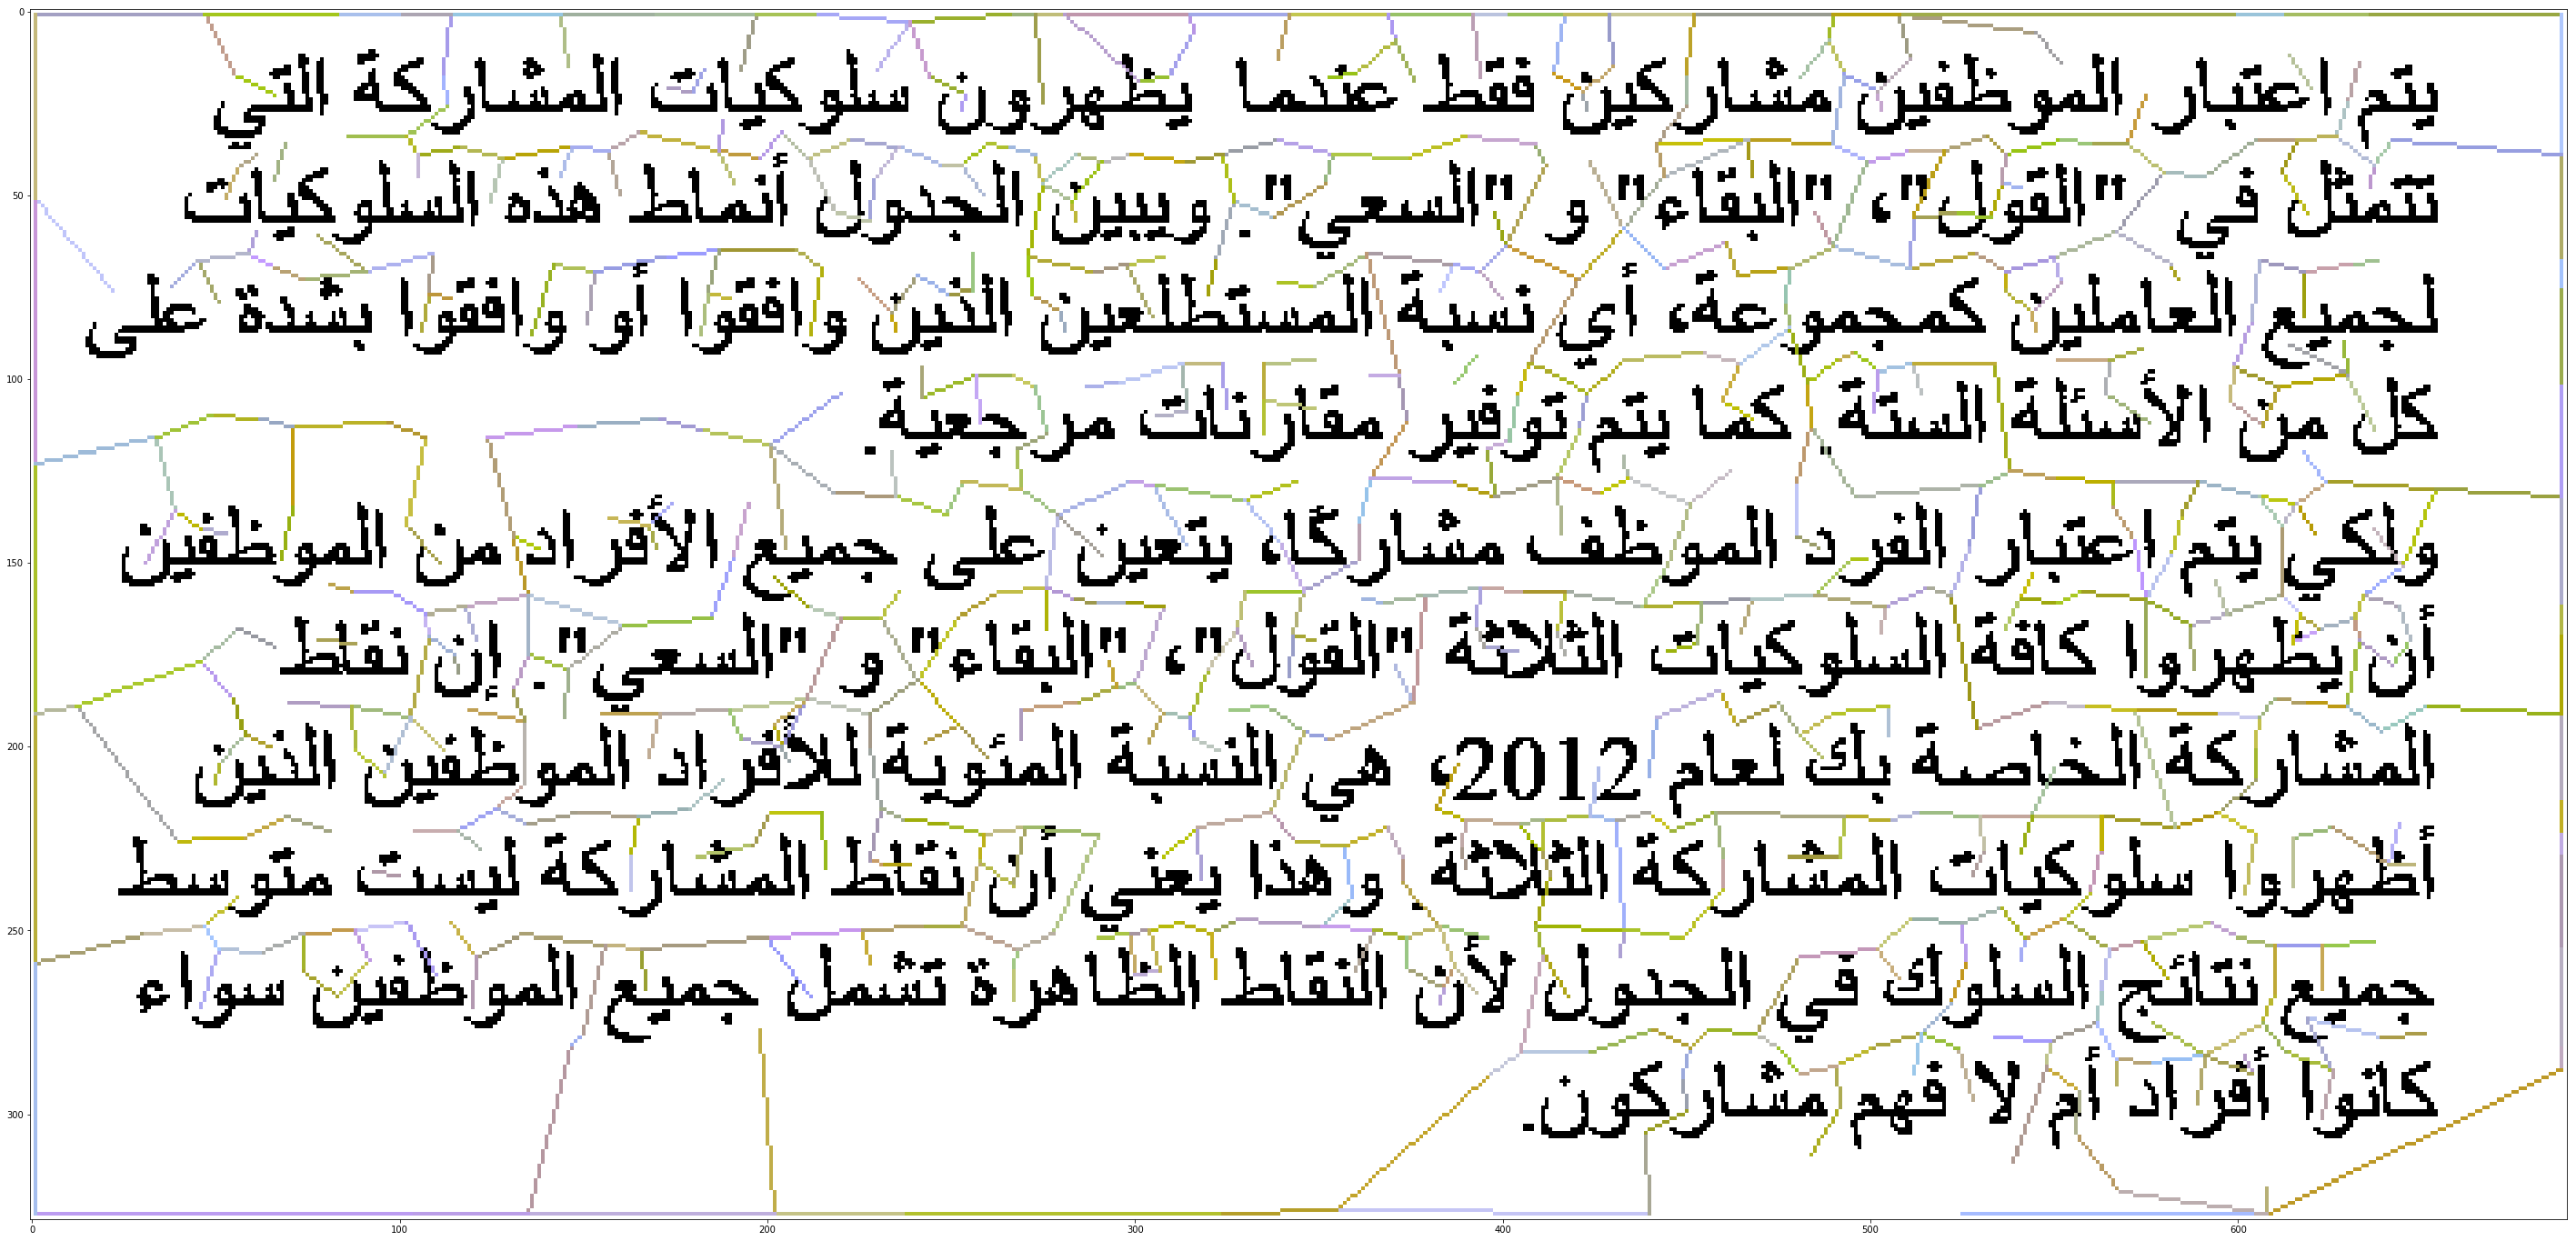

In [20]:
def edges_scan(search_mask, get_vert, start_points):
    edges = set()
    while start_points:
        start_vert = start_points.pop()
        nverts = deque([(start_vert, start_vert)])
        while nverts:
            pixel, vert = nverts.popleft()
            next_neighbors = [(n_pixel, get_vert.get(n_pixel, vert))
                              for n_pixel in adjesent_m(pixel, search_mask)]
            
            for (nextr, nextc), _ in next_neighbors:
                search_mask[nextr, nextc] = 0
                
            nverts.extend(next_neighbors)
            edges = edges.union((vert, n_vert) for _, n_vert in next_neighbors if vert != n_vert)
    
    return [((c1, r1), (c2, r2)) for (r1, c1), (r2, c2) in edges]

ROW_INDEX_VERTS = [(c, r) for r, c in LOCAL_MAX_VERTS]

EDGES = edges_scan(
    search_mask=LOCAL_DIST_MAXIMA.copy(),#cv2.dilate(LOCAL_DIST_MAXIMA, circle(3)),
    get_vert=area_to_vert(ROW_INDEX_VERTS, 5),
    start_points=set(ROW_INDEX_VERTS))

imshow(show_lines(TEXT, EDGES), figure=figure(figsize=(50, 50)))